# Example Wang and Hastie (2014)

In ***Wang & Hastie (2014) - Boosted Varying-Coefficient Regression Models for Product Demand Prediction, Journal of Computational and Graphical Statistics Vol. 23 No. 2***, the authors decribe  a boosted varying coefficient model using a slightly different approach to this package. In Section 6 their model is applied to an example problem with coefficients being smooth functions of the effect modifiers.  

In this notebook the VCBoost model is applied to this problem.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score

from vcboost import VCBooster

## Data generation

A sample dataset is created according to description in Section 6 of the paper. While the effect modifiers are 10-dimensional, only the first two effect modifiers affect the regression coefficients.

In [2]:
n = 2000  # sample size

rng = np.random.default_rng(644)

# sample of 10d effect modifiers drawn uniformly from [0, 1]
Z = rng.uniform(0, 1, n*10).reshape(n, 10)

# functions determining intercept and slope
f_beta_0 = lambda z: 2*np.sin(2*np.pi*z[:,0])**2 + np.exp(2*z[:,1]-1)
f_beta_1 = lambda z: 2*np.cos(2*np.pi*z[:,0])**2 + 8*z[:,1]*(1-z[:,1])

# model matrix of covariates
X = np.ones((n, 2))
X[:, 1] = rng.normal(0, 1, n)

# matrix of coefficients
B = np.zeros((n, 2))
B[:, 0] = f_beta_0(Z)
B[:, 1] = f_beta_1(Z)

# noise
eps = rng.normal(0, 0.5, n)

# outcomes
y = (X * B).sum(axis=1) + eps

# 20% of samples will be used as validation data
val_idx = np.zeros(n, dtype=bool)
val_idx[rng.choice(n, n // 5, replace=False)] = True

X_val, Z_val, y_val = X[val_idx], Z[val_idx], y[val_idx]
X, Z, y = X[~val_idx], Z[~val_idx], y[~val_idx]

n_val = X_val.shape[0]

## Fit varying coefficient model

A model with rather shallow trees (`max_depth=2`) is run for 1000 iterations. First halve of validation data is passed to judge appropriate number of iterations.

In [3]:
vcb = VCBooster(n_stages=1000, max_depth=2, learning_rate=0.05)

vcb.fit(X, Z, y, validation_data=(X_val[:n_val//2], Z_val[:n_val//2], y_val[:n_val//2]))

## Analysis

The next figure shows training and validation loss during the fitting process. Validation loss stopped decreasing around 400 iterations.

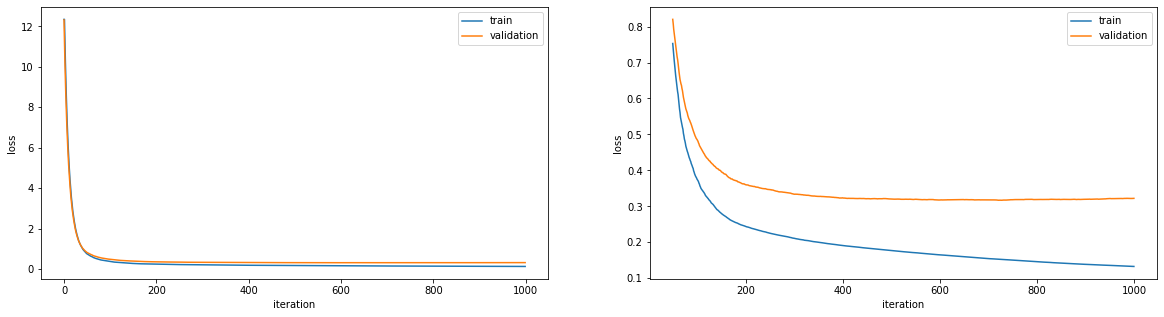

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# train and validation loss for all boosting iterations
ax[0].plot(vcb.train_loss, label='train')
ax[0].plot(vcb.validation_loss, label='validation')
ax[0].legend()

# omit first iterations
ax[1].plot(range(50, 1000), vcb.train_loss[50:], label='train')
ax[1].plot(range(50, 1000), vcb.validation_loss[50:], label='validation')
ax[1].legend()

for a in ax:
    a.set_ylabel('loss')
    a.set_xlabel('iteration')

The next figure is motivated by Figure 3 in the paper. For each effect modifier (that is z_0 and z_1 as the others are not related to the coefficients in this example) a grid of 100 values is created while keeping the other dimensions fixed at 0.5 (e.g. at the expected value of their uniform \[0, 1\] distribution).  
The true and predicted coefficients for the grids are visualized. Generally the shape of the true coefficient functions seems to be well approximated for higher numbers of stages.

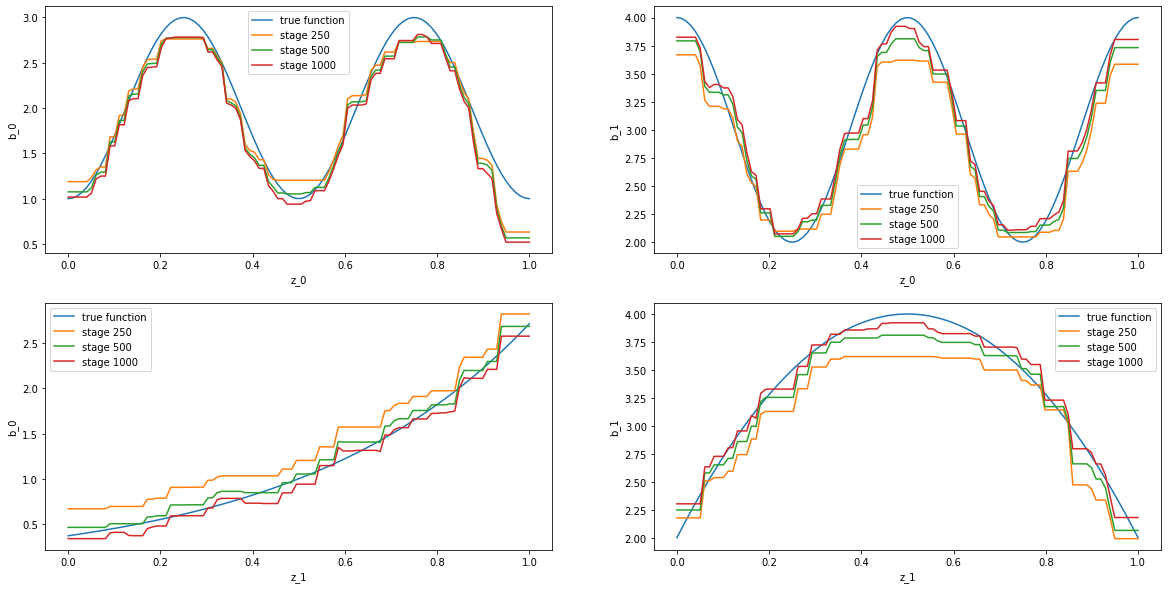

In [5]:
grid_z0 = np.ones((100, 10)) * 0.5
grid_z1 = grid_z0.copy()

grid_z0[:, 0] = np.linspace(0, 1, 100)
grid_z1[:, 1] = np.linspace(0, 1, 100)

# true coefficients for the grids are computed and plotted
b_0_0 = f_beta_0(grid_z0)
b_0_1 = f_beta_0(grid_z1)
b_1_0 = f_beta_1(grid_z0)
b_1_1 = f_beta_1(grid_z1)

fig, ax = plt.subplots(2, 2, figsize=(20, 10))

ax[0,  0].plot(grid_z0[:, 0], b_0_0, label='true function')
ax[1,  0].plot(grid_z1[:, 1], b_0_1, label='true function')
ax[0,  1].plot(grid_z0[:, 0], b_1_0, label='true function')
ax[1,  1].plot(grid_z1[:, 1], b_1_1, label='true function')

# the predicted coefficients at different stages are added to the plots
X_dummy = np.empty((100, 2))
for stage in [250, 500, 1000]:
    b_0_0_hat = vcb.predict_coefficients_at_stage(X_dummy, grid_z0, stage)[:, 0]
    b_0_1_hat = vcb.predict_coefficients_at_stage(X_dummy, grid_z1, stage)[:, 0]
    b_1_0_hat = vcb.predict_coefficients_at_stage(X_dummy, grid_z0, stage)[:, 1]
    b_1_1_hat = vcb.predict_coefficients_at_stage(X_dummy, grid_z1, stage)[:, 1]
    
    ax[0,  0].plot(grid_z0[:, 0], b_0_0_hat, label=f'stage {stage}')
    ax[1,  0].plot(grid_z1[:, 1], b_0_1_hat, label=f'stage {stage}')
    ax[0,  1].plot(grid_z0[:, 0], b_1_0_hat, label=f'stage {stage}')
    ax[1,  1].plot(grid_z1[:, 1], b_1_1_hat, label=f'stage {stage}')


# labels and legends
for a in ax[0]:
    a.set_xlabel('z_0')
    
for a in ax[1]:
    a.set_xlabel('z_1')
    
for a in ax[:, 0]:
    a.set_ylabel('b_0')
    
for a in ax[:, 1]:
    a.set_ylabel('b_1')
    
for a in ax.flatten():
    a.legend()

Based on the first halve of the validation data set 400 iterations seem reasonable. $R^2$ for the second halve of the validation dataset (not seen by the model at any point) shows that predictions for this toy example are not too bad.

In [6]:
display(f'Validation R2 after 400 stages: {r2_score(y_val[n_val//2:], vcb.predict_stage(X_val[n_val//2:], Z_val[n_val//2:], stage=400)):0.3f}')

'Validation R2 after 400 stages: 0.945'